In [1]:
import os
import cv2
import math
from PIL import Image
from PIL import ImageFilter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numbers
from tqdm import tqdm

import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as T
from torch.nn import functional as F

In [2]:
IMG_EXTENSIONS = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP']

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def get_paths_from_images(apath):
    assert os.path.isdir(apath), '{:s} is not a valid directory'.format(apath)
    imgList = []
    for dirpath, _, fnames in sorted(os.walk(apath)):
        for fname in sorted(fnames):
            if is_image_file(fname):
                img_path = os.path.join(dirpath, fname)
                imgList.append(img_path)
    assert imgList, '{:s} has no valid image file'.format(apath)
    return imgList

In [3]:
datapath ='C:/Users/LTB/Desktop/myDesktop/mytests/blur_noise_gamma/samples'
# img_0 =  Image.open('./samples/01/00000.png').convert('RGB')
# img_1 =  Image.open('./samples/02/01000.png').convert('RGB')

In [4]:
imgList = get_paths_from_images(datapath)
len(imgList)

8

In [5]:
def disp_single(img):
    plt.axis("off")
    plt.imshow(img)
    plt.show()

In [6]:
imgs = []
n_data = len(imgList)
for i in range(n_data):
    imgs.append(Image.open(imgList[i]).convert('RGB'))

In [7]:
n_data

8

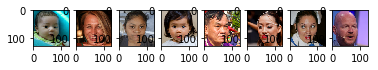

In [8]:
fig, axs = plt.subplots(1, n_data)
for idx in range(n_data):
    axs[idx].imshow(imgs[idx])

# fig = plt.figure()
# ax1 = fig.add_subplot(1,2,1)
# ax1.imshow(img_0)
# ax1.set_title("Original")
# ax2 = fig.add_subplot(1,2,2)
# ax2.imshow(img_1)
# ax2.set_title("Original")

In [9]:
def tensor_to_img(output):
    min_max=(0, 1)
    output = output.squeeze().float().cpu().clamp_(*min_max)  # clamp
    output = (output - min_max[0]) / (min_max[1] - min_max[0])  # to range [0,1]
    n_img = len(output)
    img_np = make_grid(output, nrow=int(math.sqrt(n_img)), normalize=False).numpy()
    # img_np = np.transpose(img_np[[2, 1, 0], :, :], (1, 2, 0))  # HWC, BGR
    img_np = np.transpose(img_np[[0, 1, 2], :, :], (1, 2, 0))  # HWC, BGR
    img_np = (img_np * 255.0).round()
    return img_np.astype(np.uint8)

In [10]:
train_transform = T.Compose([ # refer to https://pytorch.org/docs/stable/torchvision/transforms.html for more build-in online data augmentation
        T.ToTensor(),
])
data_example = datasets.ImageFolder(datapath, train_transform)

In [11]:
len(data_example)

8

In [12]:
loader_example = DataLoader(data_example, batch_size = 1)

In [13]:
len(loader_example)

8

In [14]:
def add_noise(img, n_val=25, is_random=False):
    if is_random:
        noise = torch.zeros(img.size())
        stdn = np.random.uniform(0, n_val, size=noise.size()[0])
        for n in range(noise.size()[0]):
            sizeN = noise[0,:,:,:].size()
            noise[n,:,:,:] = torch.FloatTensor(sizeN).normal_(mean=0, std=stdn[n]/255.)
    else:
        noise = torch.FloatTensor(img_train.size()).normal_(mean=0, std=n_val/255.)
        
    img_noise = img + noise
    if is_random:
        n_val = float(stdn)
    return img_noise, noise, n_val

In [15]:
stdn = np.random.uniform(0, 25, size=(1,3,128,128)[0])
stdn

array([2.74818997])

In [16]:
stdn = float(stdn)
stdn

2.7481899745840948

In [17]:
def noise_to_img(output):
    min_max=(0, 1)
    output = output.squeeze().float().cpu().clamp_(*min_max)  # clamp
    output = (output - min_max[0]) / (min_max[1] - min_max[0])  # to range [0,1]
    n_img = len(output)
    img_np = make_grid(output, nrow=int(math.sqrt(n_img)), normalize=False).numpy()
    # img_np = np.transpose(img_np[[2, 1, 0], :, :], (1, 2, 0))  # HWC, BGR
    img_np = np.transpose(img_np[[0, 1, 2], :, :], (1, 2, 0))  # HWC, BGR
    img_np = (img_np * 255.0).round()
    img_np = (img_np + 128.0).round().clip(0, 255)
    return img_np.astype(np.uint8)

100%|████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 27.03it/s]


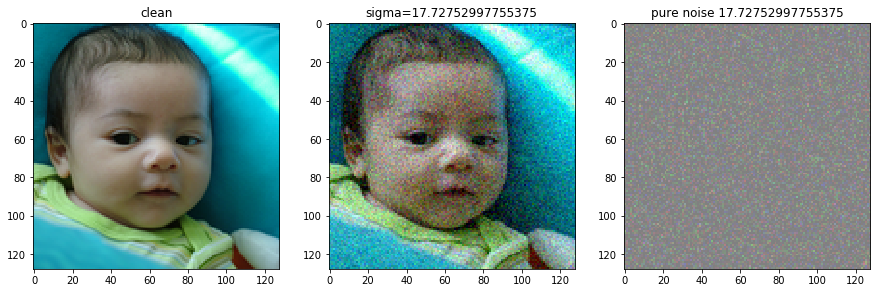

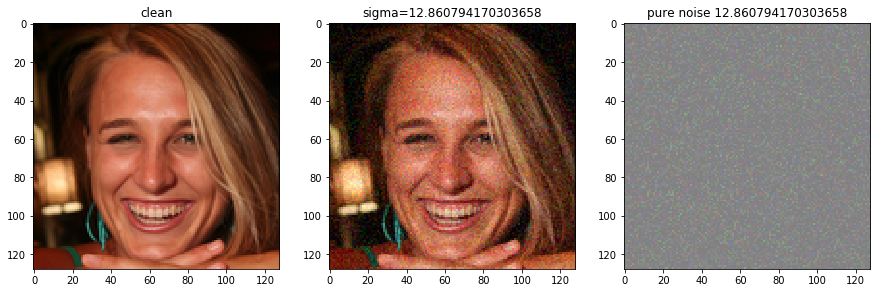

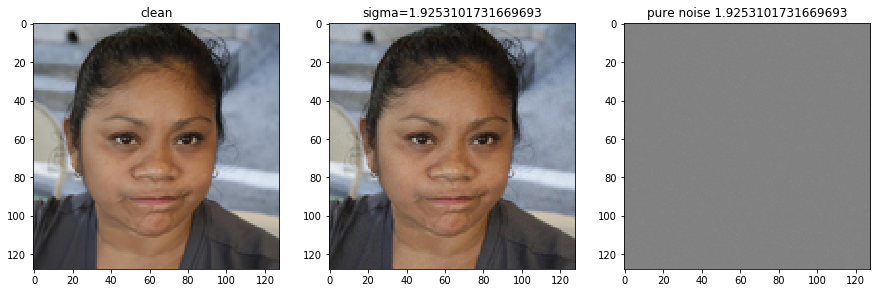

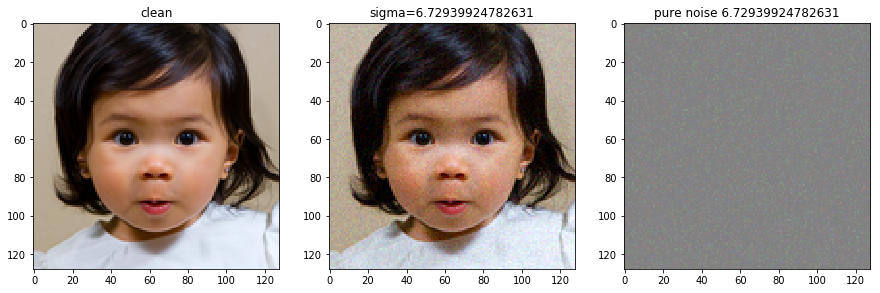

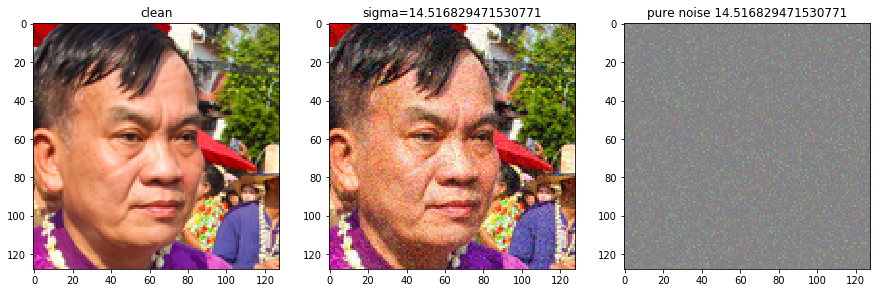

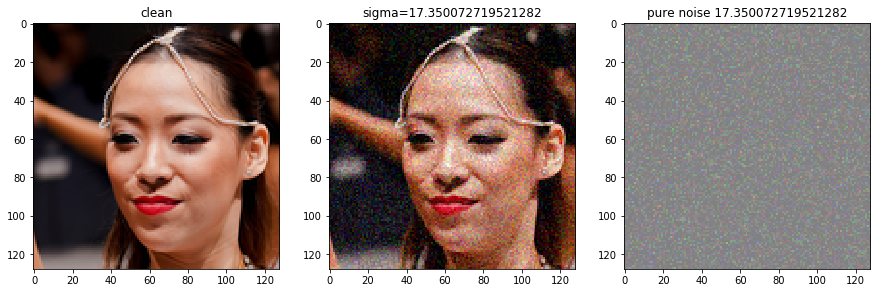

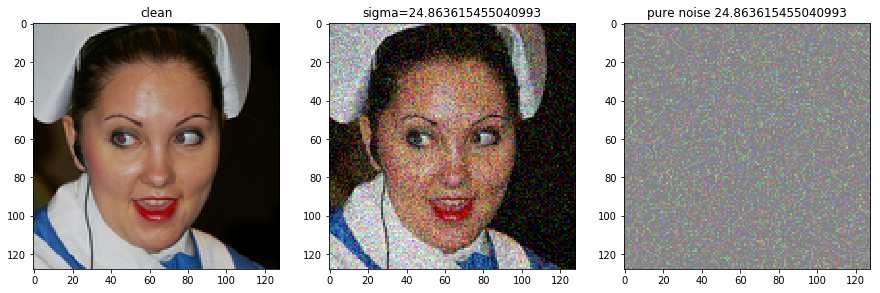

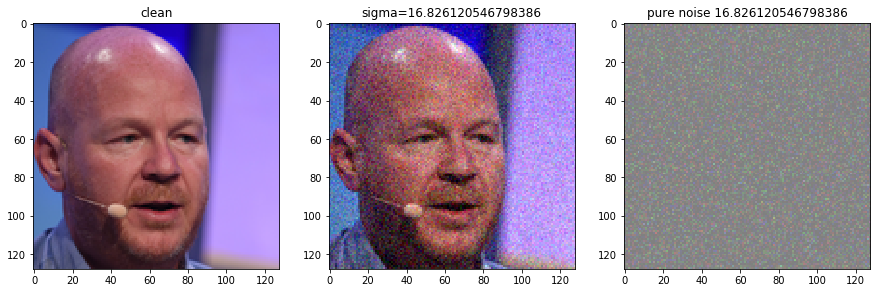

In [18]:
img_t = []
for data, _ in tqdm(iter(loader_example)):
#     print(data.size())
#     img_t.append(data)
    img_gt = data.clone() # original clean
    #img_noise = data.clone() # noise
    #img_dark = data.clone()
    #img_blur = data.clone()    
    img_noise, noise, n_val = add_noise(img_gt, is_random=True)
    img_gt = tensor_to_img(img_gt)
    img_noise = tensor_to_img(img_noise)
    noise = noise_to_img(noise)
    
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(img_gt)
    ax1.set_title("clean")
    
    ax2 = fig.add_subplot(1,3,2)
    ax2.imshow(img_noise)
    ax2.set_title("sigma={}".format(n_val))

    ax3 = fig.add_subplot(1,3,3)
    ax3.imshow(noise)
    ax3.set_title("pure noise {}".format(n_val))

In [19]:
class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, kernel_size, sigma, channels=3, dim=2):
        super(GaussianSmoothing, self).__init__()
        
        self.kernel_size = kernel_size
        
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / std) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        p = (self.kernel_size - 1)//2
        input =F.pad(input, (p, p, p, p), mode='reflect')        
        
        return self.conv(input, weight=self.weight, groups=self.groups)


# smoothing = GaussianSmoothing(3, 5, 1)
# input = torch.rand(1, 3, 100, 100)
# input = F.pad(input, (2, 2, 2, 2), mode='reflect')
# output = smoothing(input)

In [20]:
import random
random.randrange(3, 10, 2)

3

In [21]:
random.randrange(0, 6) * 20

60

In [22]:
def sub_img(img1, img2):
    img_sub = img1.astype(np.int16) - img2.astype(np.int16)
    # for visual
    img_sub += 128
    return img_sub.clip(0, 255).astype(np.uint8)

100%|████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 15.24it/s]


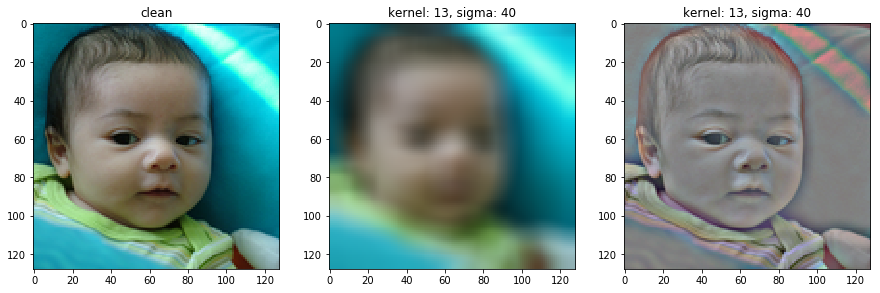

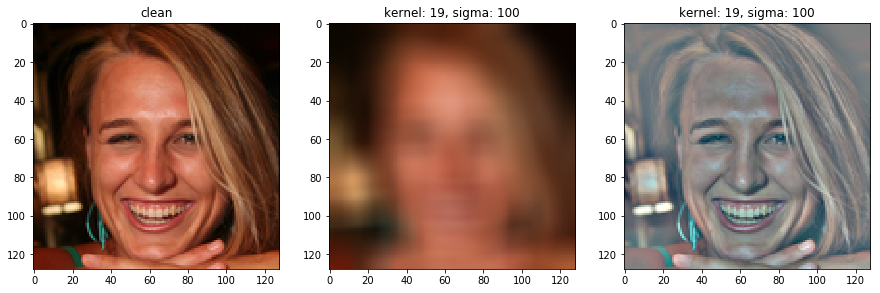

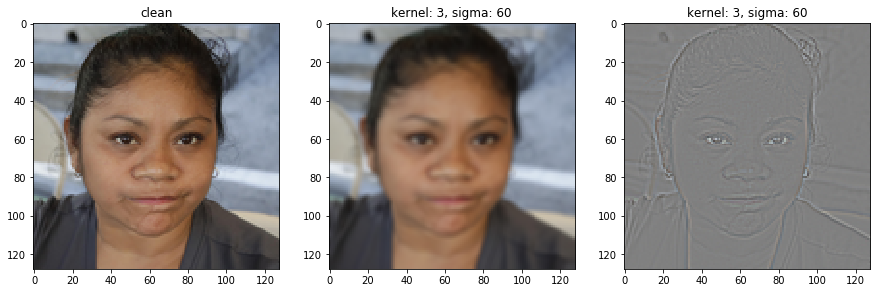

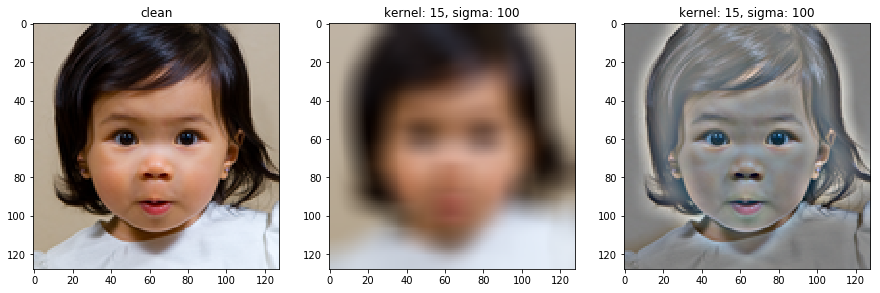

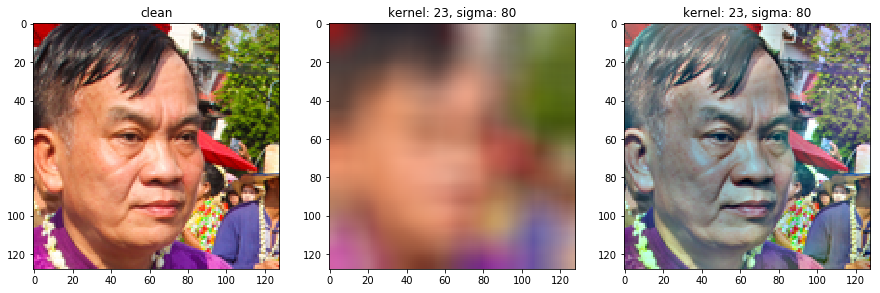

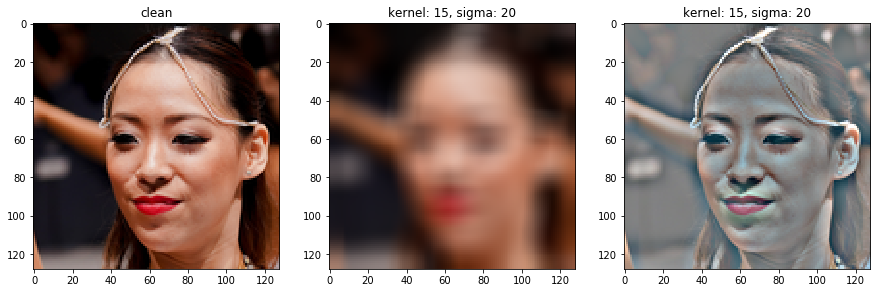

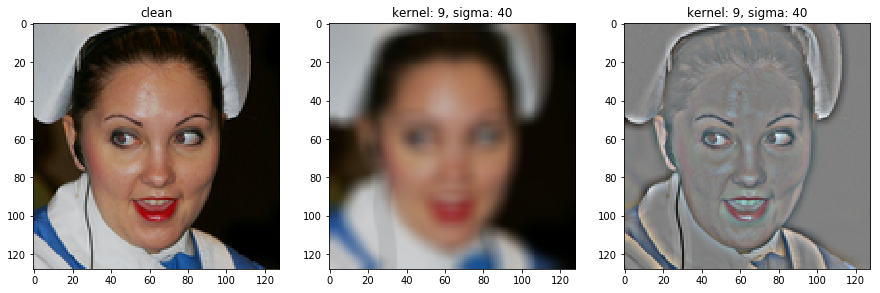

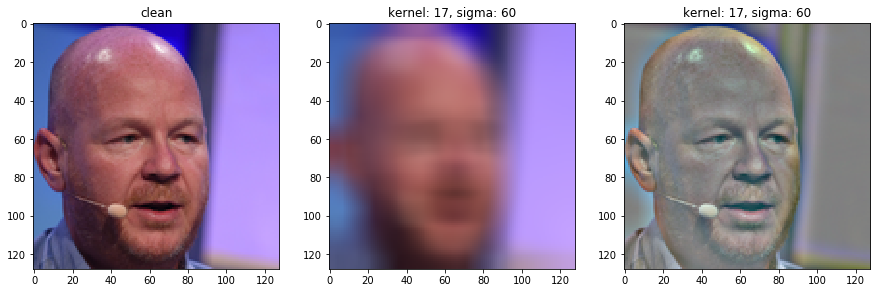

In [23]:
img_t = []
for data, _ in tqdm(iter(loader_example)):
#     print(data.size())
#     img_t.append(data)
    img_gt = data.clone() # original clean
    #img_noise = data.clone() # noise
    #img_dark = data.clone()
    #img_blur = data.clone()    
    
    kernel_size = random.randrange(1, 26, 2)
    sigma = random.randrange(1, 6) * 20
    
    smoothing = GaussianSmoothing(kernel_size, sigma)    
    img_blur = smoothing(img_gt)
    
    img_gt = tensor_to_img(img_gt)
    img_blur = tensor_to_img(img_blur)
    # noise = noise_to_img(noise)
    
    
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(img_gt)
    ax1.set_title("clean")
    
    ax2 = fig.add_subplot(1,3,2)
    ax2.imshow(img_blur)
    ax2.set_title("kernel: {}, sigma: {}".format(kernel_size, sigma))
    
    ax3 = fig.add_subplot(1,3,3)
    im = sub_img(img_gt, img_blur)
    ax3.imshow(im)
    ax3.set_title("kernel: {}, sigma: {}".format(kernel_size, sigma))

#     ax3 = fig.add_subplot(1,3,3)
#     ax3.imshow(noise)
#     ax3.set_title("pure noise {}".format(n_val))

In [24]:
random.uniform(0,1)

0.6415710524840302

In [25]:
# def add_noise(img, n_val=25, is_random=False):
#     if is_random:
#         noise = torch.zeros(img.size())
#         stdn = np.random.uniform(0, n_val, size=noise.size()[0])
#         for n in range(noise.size()[0]):
#             sizeN = noise[0,:,:,:].size()
#             noise[n,:,:,:] = torch.FloatTensor(sizeN).normal_(mean=0, std=stdn[n]/255.)
#     else:
#         noise = torch.FloatTensor(img_train.size()).normal_(mean=0, std=n_val/255.)
        
#     img_noise = img + noise
#     if is_random:
#         n_val = float(stdn)
#     return img_noise, noise, n_val

def adjust_gamma(img, gamma=3, is_random=False):
    assert gamma > 0, 'Gamma must be positive.'
    if is_random:
        gamma = random.uniform(0, gamma)
    invGamma = 1.0 / gamma
    img_gamma = img.clone()
    img_gamma = img_gamma.pow_(invGamma).clamp_(0., 1.)
    
    return img_gamma, gamma


100%|████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.79it/s]


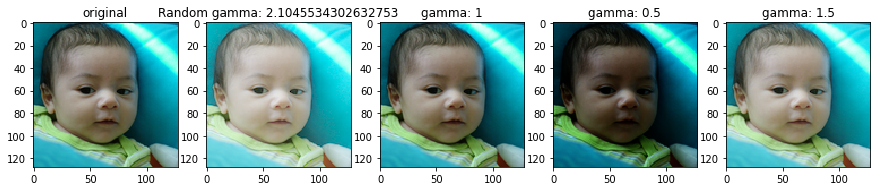

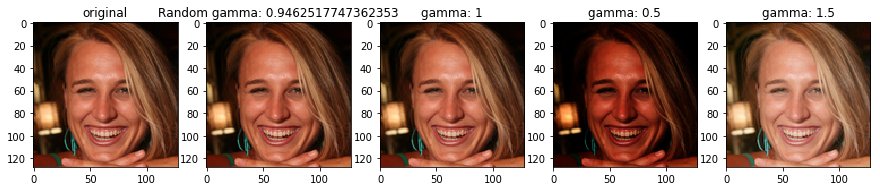

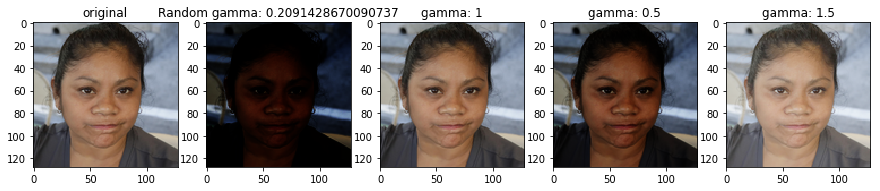

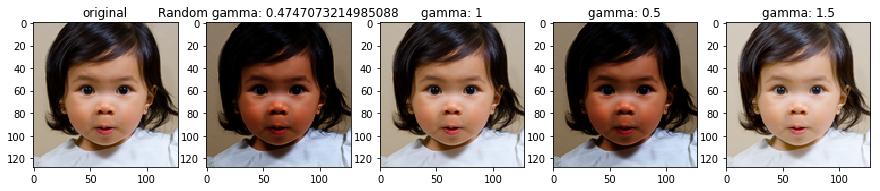

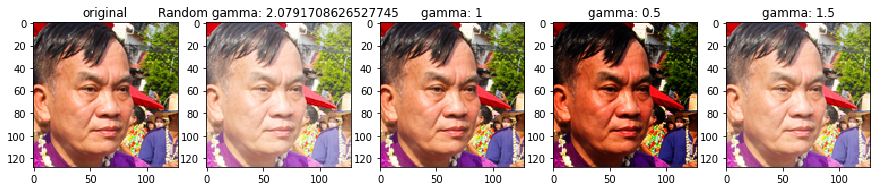

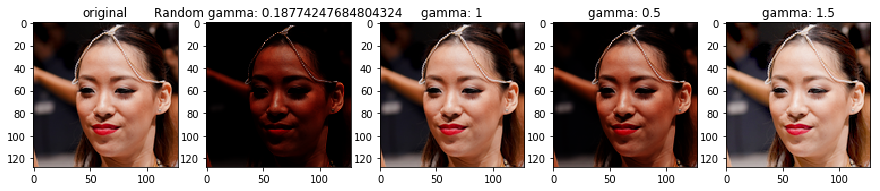

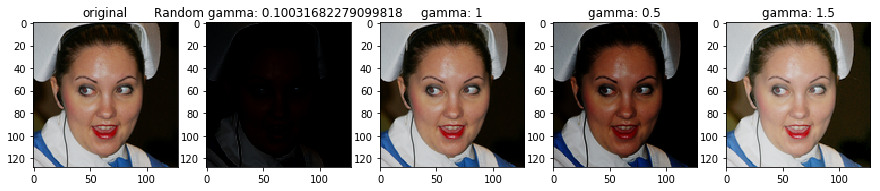

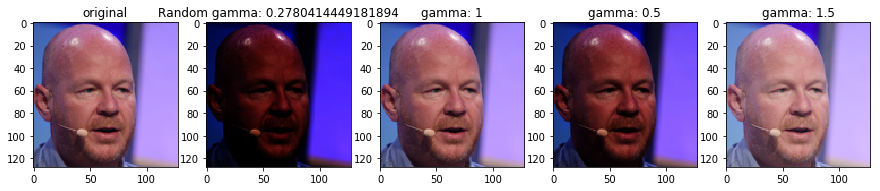

In [26]:
for data, _ in tqdm(iter(loader_example)):
#     print(data.size())
#     img_t.append(data)
    img_gt = data.clone() # original clean
    #img_noise = data.clone() # noise
    #img_dark = data.clone()
    #img_blur = data.clone()    
       
    img_g_rand, gr = adjust_gamma(img_gt, gamma=3, is_random=True)
    img_g_1, g1 = adjust_gamma(img_gt, gamma=1, is_random=False)
    img_g_05, g05 = adjust_gamma(img_gt, gamma=0.5, is_random=False)
    img_g_15, g15 = adjust_gamma(img_gt, gamma=1.5, is_random=False)
    
    img_gt = tensor_to_img(img_gt)
    img_g_rand = tensor_to_img(img_g_rand)
    img_g_1 = tensor_to_img(img_g_1)
    img_g_05 = tensor_to_img(img_g_05)
    img_g_15 = tensor_to_img(img_g_15)
    
    # noise = noise_to_img(noise)
    
    
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(1,5,1)
    ax1.imshow(img_gt)
    ax1.set_title("original")
    
    ax2 = fig.add_subplot(1,5,2)
    ax2.imshow(img_g_rand)
    ax2.set_title("Random gamma: {}".format(gr))
    
    ax3 = fig.add_subplot(1,5,3)
    ax3.imshow(img_g_1)
    ax3.set_title("gamma: {}".format(g1))
    
    ax4 = fig.add_subplot(1,5,4)
    ax4.imshow(img_g_05)
    ax4.set_title("gamma: {}".format(g05))
    
    ax5 = fig.add_subplot(1,5,5)
    ax5.imshow(img_g_15)
    ax5.set_title("gamma: {}".format(g15))

100%|████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.10it/s]


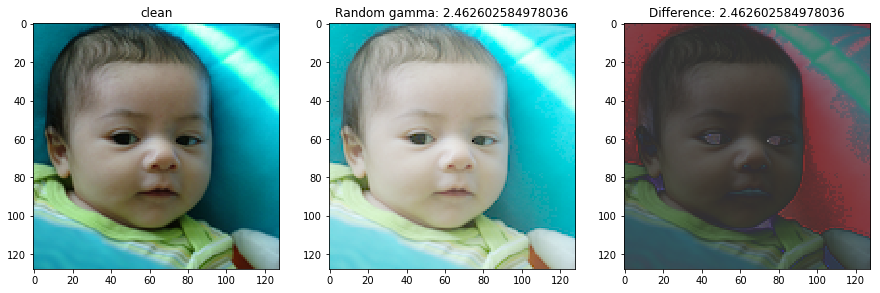

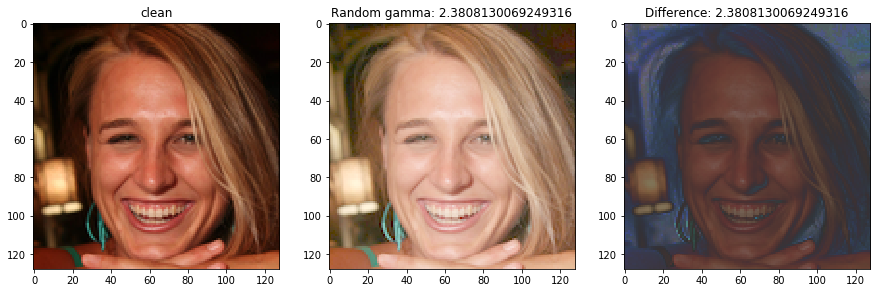

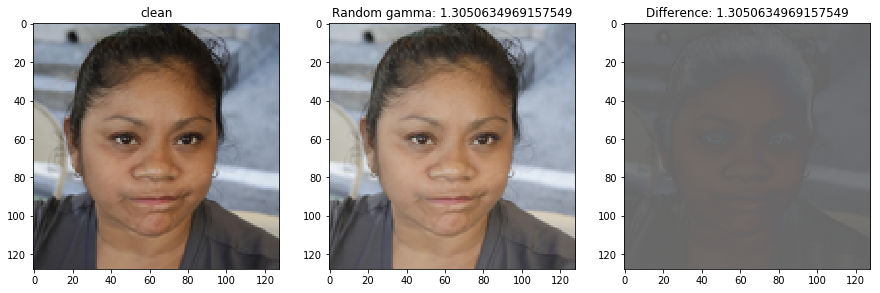

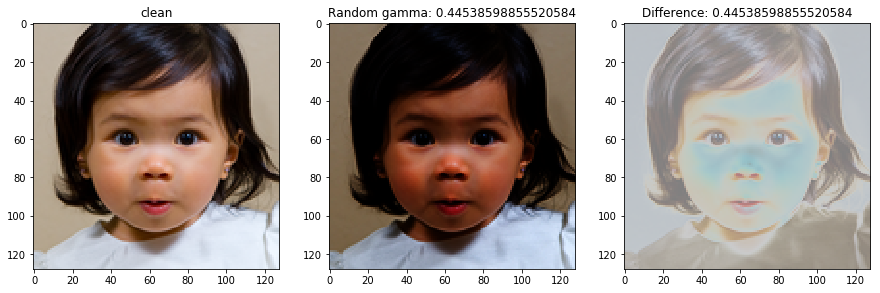

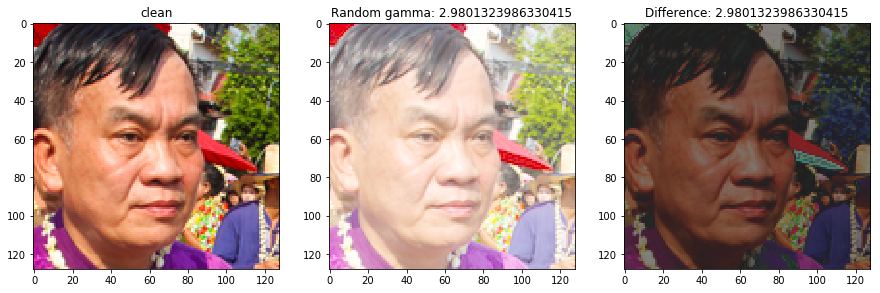

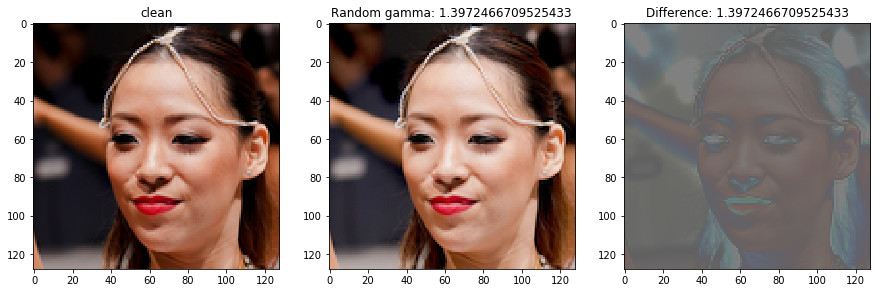

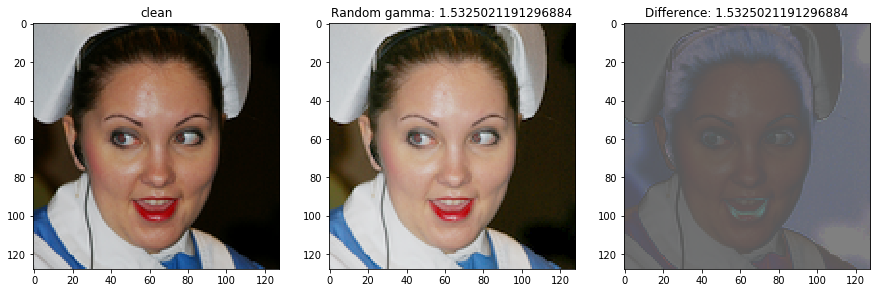

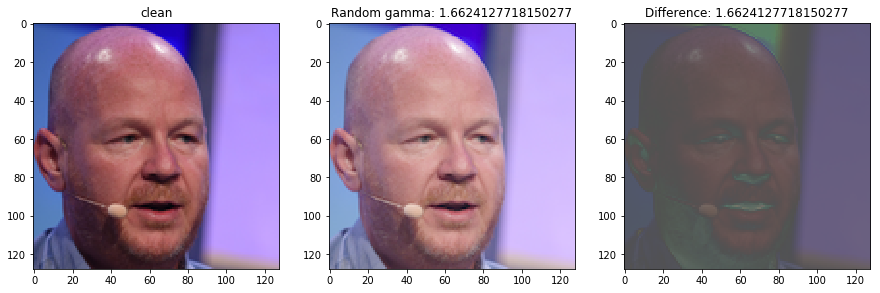

In [27]:
for data, _ in tqdm(iter(loader_example)):
#     print(data.size())
#     img_t.append(data)
    img_gt = data.clone() # original clean
    #img_noise = data.clone() # noise
    #img_dark = data.clone()
    #img_blur = data.clone()    
       
    img_g_rand, gr = adjust_gamma(img_gt, gamma=3, is_random=True)
    #img_g_1, g1 = adjust_gamma(img_gt, gamma=1, is_random=False)
    #img_g_05, g05 = adjust_gamma(img_gt, gamma=0.5, is_random=False)
    #img_g_15, g15 = adjust_gamma(img_gt, gamma=1.5, is_random=False)
    
    img_gt = tensor_to_img(img_gt)
    img_g_rand = tensor_to_img(img_g_rand)
#     img_g_1 = tensor_to_img(img_g_1)
#     img_g_05 = tensor_to_img(img_g_05)
#     img_g_15 = tensor_to_img(img_g_15)
    
    # noise = noise_to_img(noise)
    
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(img_gt)
    ax1.set_title("clean")
    
    ax2 = fig.add_subplot(1,3,2)
    ax2.imshow(img_g_rand)
    ax2.set_title("Random gamma: {}".format(gr))
    
    ax3 = fig.add_subplot(1,3,3)
    im = sub_img(img_gt, img_g_rand)
    ax3.imshow(im)
    ax3.set_title("Difference: {}".format(gr))